<a href="https://colab.research.google.com/github/Eddiebee/computer_vision_classification_models/blob/main/is_flugelhorn_computer_vision_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -Uqq fastai duckduckgo_search

**A computer vision model to predict if an image is that of a flugelhorn**

The basic steps are:


1.   Use DuckDuckGo to search for images of "flugelhorn photos"
2.   Use DuckDuckGo to search for images of "trumpet photos"
3. Fine-tune a pretrained neural network to recognise these two groups.
4. Try running this model on a picture of a flugelhorn and see if it works.



In [13]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
  print(f"Searching for '{term}'")
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [14]:
# we'll start by searching for a flugelhorn photo and see the result we get
urls = search_images('flugelhorn photos', max_images=1)
urls[0]

Searching for 'flugelhorn photos'


'https://media.musiciansfriend.com/is/image/MMGS7/1646R-Professional-Series-Bb-Flugelhorn-1646RL-Lacquer/J20573000002000-00-1600x1600.jpg'

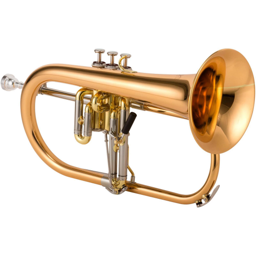

In [15]:
# let's then download the URL and take a look at it:
from fastdownload import download_url
dest = "flugelhorn.jpg"
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
img = Image.open(dest)
img.to_thumb(256, 256)

Searching for 'trumpet photos'


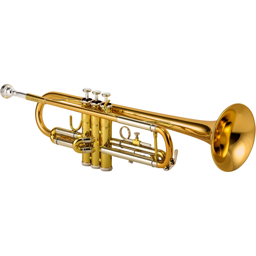

In [16]:
# we're gonna do the same thing for a trumpet photo
download_url(search_images('trumpet photos', max_images=1)[0], 'trumpet.jpg',
             show_progress=False)
Image.open('trumpet.jpg').to_thumb(256, 256)

In [17]:
# I believe this a getting more of the data needed to train our model

searches = 'flugelhorn', 'trumpet'
path = Path('flugelhorn_or_not')
from time import sleep

for search in searches:
  dest = (path/search)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{search} photo'))
  sleep(10) # Pause between searched to avoid over-loading the server
  download_images(dest, urls=search_images(f'{search} gold photo'))
  sleep(10)
  download_images(dest, urls=search_images(f'{search} silver photo'))
  sleep(10)
  resize_images(path/search, max_size=400, dest=path/search)

Searching for 'flugelhorn photo'
Searching for 'flugelhorn gold photo'
Searching for 'flugelhorn silver photo'
Searching for 'trumpet photo'
Searching for 'trumpet gold photo'
Searching for 'trumpet silver photo'


In [18]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

To train a model, we'll use the DataLoaders.

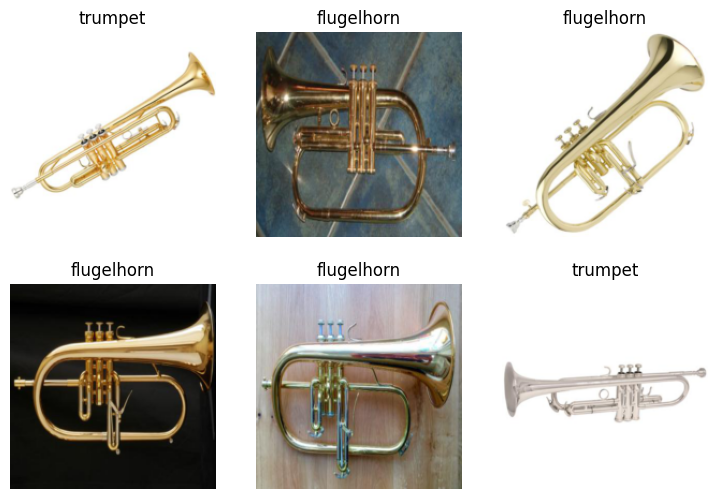

In [19]:
dls = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)


dls.show_batch(max_n=6)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.871956,0.180340,0.100000,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.226504,0.043217,0.014286,00:58
1,0.135899,0.004191,0.000000,00:57
2,0.090551,0.001902,0.000000,00:57


"Fine-tuning" a model means that we're starting a _pretrained model_, and adjusting the weights a little bit so hat the model learns to recognise our particular dataset.

In [23]:
is_flugelhorn,_,probs = learn.predict(PILImage.create('flugelhorn.jpg'))
print(f"This is a: {is_flugelhorn}.")
print(f"Probability it's a flugelhorn: {probs[0]:.4f}")

This is a: flugelhorn.
Probability it's a flugelhorn: 1.0000


**Wow!**